In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier

from imblearn.over_sampling import RandomOverSampler

In [2]:
import folium
from folium import plugins
import ipywidgets
import geocoder


In [3]:
def percentage_nulls(df):
    number_nulls = pd.DataFrame(df.isnull().sum(),columns=['Total'])
    number_nulls['% nulls'] = round((number_nulls['Total'] / df.shape[0])*100,1)
    
    return number_nulls

In [4]:
# Extraccion datos fuente
df_earthquakes = pd.read_csv('..\Dataset\earthquakes-1500-2021.csv')
df_sociodemo = pd.read_csv('..\Dataset\socio_demografico.csv')

In [5]:
df_earthquakes = df_earthquakes[df_earthquakes['Year'] >=1960]

In [76]:
df_sociodemo.Year.describe()

count     390.00000
mean     2004.50000
std         8.66656
min      1990.00000
25%      1997.00000
50%      2004.50000
75%      2012.00000
max      2019.00000
Name: Year, dtype: float64

In [6]:
df_earthquakes['Density'] = 0
# df_earthquakes['IDH'] = 0

for i in df_sociodemo.index:
    axo = df_sociodemo['Year'][i]
    country = df_sociodemo['Country'][i]
    density = df_sociodemo['Density'][i]
    idh = df_sociodemo['IDH'][i]
    
    df_earthquakes.loc[(df_earthquakes['Year'] == axo) & (df_earthquakes['Country'] == country), 'Density'] = density
    # df_earthquakes.loc[(df_earthquakes['Year'] == axo) & (df_earthquakes['Country'] == country), 'IDH'] = idh

# df_earthquakes = df_earthquakes[df_earthquakes['Density'] > 0]

In [66]:
df_earthquakes.head(5)

,Year,Mo,Dy,Country,Area,Region,Location Name,Latitude,Longitude,Focal Depth (km),...,Death Description,Injuries,Injuries Description,Damage ($Mil),Damage Description,Houses Destroyed,Houses Destroyed Description,Houses Damaged,Houses Damaged Description,Density
4095,1990,2.0,8.0,PHILIPPINES,NaN,170.0,"PHILIPPINES: BOHOL, CEBU, CAGAYAN DE ORO, CAM...",9.755,124.694,26.0,...,2.0,300.0,3.0,0.9,1.0,NaN,NaN,600.0,3.0,203
4096,1990,2.0,20.0,JAPAN,NaN,30.0,JAPAN: NEAR S. COAST OF HONSHU,34.706,139.252,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,327
4097,1990,2.0,28.0,USA,CA,150.0,"CALIFORNIA: S, CLAREMONT, COVINA",34.140,-117.700,5.0,...,NaN,30.0,1.0,12.7,3.0,NaN,NaN,NaN,NaN,26
4102,1990,3.0,26.0,PHILIPPINES,NaN,170.0,PHILIPPINES: SANTIAGO,9.253,125.606,39.0,...,1.0,2.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,203
4105,1990,4.0,17.0,CHINA,NaN,40.0,CHINA: S XINJIANG: WUQIA COUNTY,39.436,74.900,33.0,...,NaN,2.0,1.0,NaN,2.0,NaN,3.0,NaN,NaN,120


In [7]:
# Nos quedamos con columnas que nos servirán para el análisis
df_earthquakes = df_earthquakes[['Year', 'Mo', 'Dy', 'Country', 'Region', 'Location Name', 'Latitude', 'Longitude','Focal Depth (km)', 'Mag', 'Death Description', 'Injuries Description', 'Damage Description','Density']]
# , 'Density', 'IDH'
df_earthquakes.head(3)

,Year,Mo,Dy,Country,Region,Location Name,Latitude,Longitude,Focal Depth (km),Mag,Death Description,Injuries Description,Damage Description,Density
3191,1960,1.0,13.0,PERU,160.0,"PERU: AREQUIPA,CHUQUIBAMBA,CARAVELI,COTAHUASI",-15.75,-72.75,160.0,7.8,2.0,3.0,3.0,0
3192,1960,1.0,15.0,PERU,160.0,"PERU: LIMA,NAZCA,ICA,HUANCAVELIC,PALPA,HUAITARA",-15.00,-75.00,150.0,7.0,2.0,NaN,1.0,0
3193,1960,2.0,2.0,CHINA,30.0,CHINA: GANSU PROVINCE,33.80,104.50,NaN,5.3,NaN,NaN,1.0,0


In [ ]:
# Cambio de tipo de datos para datos numéricos
# pd.to_numeric(s, downcast='integer')
df_earthquakes[['Mo','Dy','Region']] = df_earthquakes[['Mo','Dy','Region']].astype('int64')

In [69]:
df_earthquakes.Year.describe()

count     899.000000
mean     2006.349277
std         7.965427
min      1990.000000
25%      2001.000000
50%      2007.000000
75%      2013.000000
max      2019.000000
Name: Year, dtype: float64

In [9]:
# Imputar valores faltantes en Depth y Magnitud, se considera el promedio por región para ambos casos
columnasNull = ['Focal Depth (km)','Mag']

for col in columnasNull:
    region = df_earthquakes[df_earthquakes[col].isnull()]['Region'].array
    for reg in region:
        val = df_earthquakes[df_earthquakes['Region'] == reg][col].mean()
        df_earthquakes.loc[(df_earthquakes['Region'] == reg) & (df_earthquakes[col].isnull()), col] = val


In [55]:
# Sismos desde 1990 a la fecha
df_earthquakes.groupby(['Country']).agg({'Mag':('count','min','mean','max'),'Year':(min, max)}).sort_values('Country')

Mag                      Year      
            count  min      mean  max   min   max
Country                                          
CHILE          34  5.4  6.861765  8.8  1995  2019
CHINA         168  3.4  5.510119  7.9  1990  2019
GREECE         28  5.2  6.060714  6.9  1990  2019
INDIA          56  3.5  5.289286  7.7  1991  2019
INDONESIA     146  4.4  6.517808  9.1  1990  2019
IRAN          101  4.0  5.591854  7.7  1990  2019
JAPAN          91  4.6  6.582418  9.1  1990  2019
MEXICO         33  5.1  6.603030  8.2  1995  2019
PERU           40  4.4  6.327500  8.4  1990  2019
PHILIPPINES    48  4.1  6.250000  7.8  1990  2019
RUSSIA         30  3.2  6.793333  8.3  1991  2017
TURKEY         54  4.0  5.550000  7.6  1990  2019
USA            70  1.6  5.852857  7.9  1990  2019

In [10]:
# df_earhquakes_mexico = 
df_earthquakes[df_earthquakes['Country'] == 'MEXICO'].nlargest(20, 'Mag')[['Year','Mag']]

,Year,Mag
5447,2017,8.2
3951,1985,8.1
4297,1995,8.0
3352,1965,7.8
3742,1978,7.7
3750,1979,7.6
3952,1985,7.6
3439,1968,7.5
3575,1973,7.5
4408,1999,7.5


# Cantidad de temblores de 1990 a la fecha por país

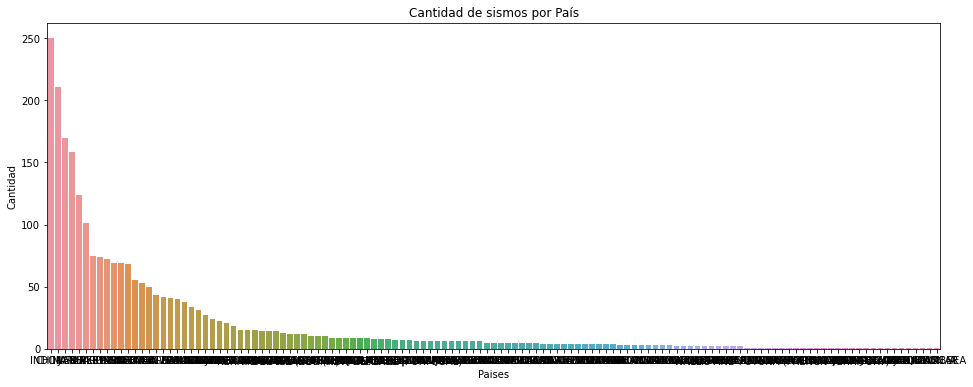

In [11]:
#Promedio de magnitud de temblores por Pais
df_avg_country = df_earthquakes.groupby('Country').agg({'Mag':'count'}).reset_index().sort_values('Mag', ascending=False)
plt.figure(figsize=(16,6))
sns.barplot(x='Country', y='Mag', data=df_avg_country)
plt.title('Cantidad de sismos por País')
plt.xlabel('Paises')
plt.ylabel('Cantidad')
plt.show()

# Magnitud y su relación con la profundidad del epicentro

Text(0.5, 0, 'Magnitud (escala de Righter)')

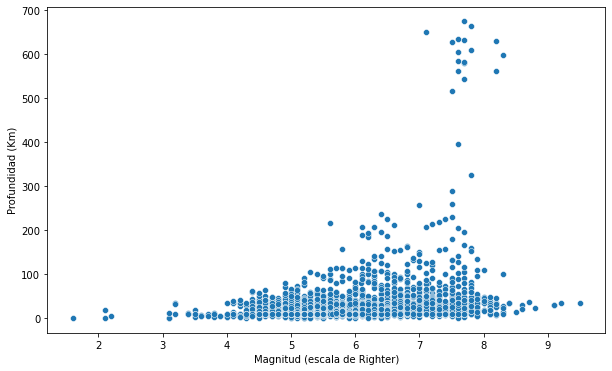

In [12]:
# Magnitud y su relación con la profundidad del epicentro
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_earthquakes, x='Mag', y = 'Focal Depth (km)')
plt.ylabel('Profundidad (Km)')
plt.xlabel('Magnitud (escala de Righter)')

# Observación por magnitud de los sismos

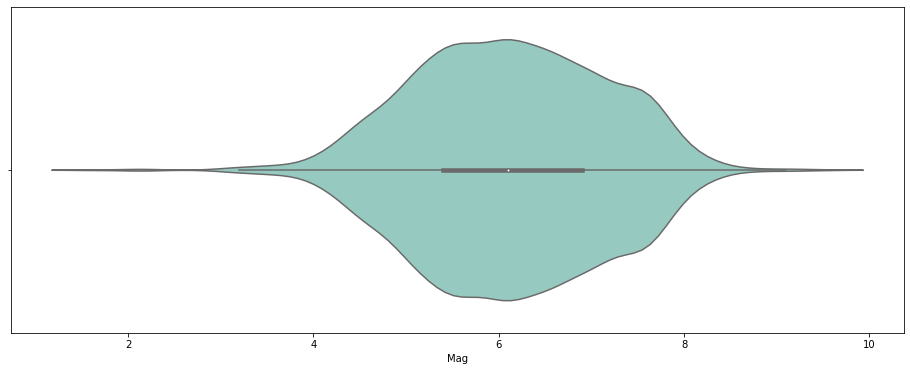

In [13]:
plt.figure(figsize=(16,6))
sns.violinplot(x=df_earthquakes['Mag'], palette='Set3')
plt.show()

# Distribución sismica en el mundo

In [ ]:
df_earthquakes_mapa = df_earthquakes[['Latitude', 'Longitude', 'Mag']]
mapa_markers_sismos = folium.Map(location=[24.534896, -42.514975], zoom_start=3, tiles='cartodbpositron')

for i in df_earthquakes_mapa.index:
    df_earthquakes_mapa['Latitude'][i]
    df_earthquakes_mapa['Longitude'][i]
    location = [df_earthquakes_mapa['Latitude'][i], df_earthquakes_mapa['Longitude'][i]]
    folium.CircleMarker(radius=df_earthquakes_mapa['Mag'][i], location=location,popup='Personalizad', color='crimson', fill='red').add_to(mapa_markers_sismos)

mapa_markers_sismos

# Comportamiento sismico en México

<AxesSubplot:xlabel='Year', ylabel='Mag'>

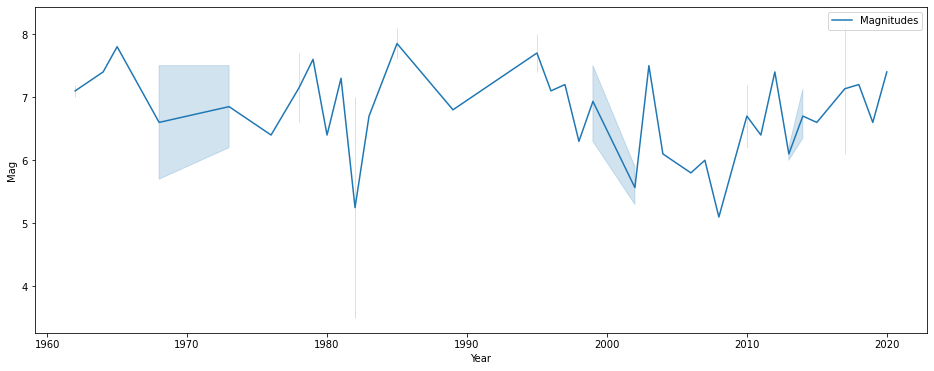

In [15]:
df_earthquakes_mex = df_earthquakes[df_earthquakes['Country'] == 'MEXICO'][['Year','Mag']].reset_index(drop=True)
plt.figure(figsize=(16,6))
sns.lineplot(data=df_earthquakes_mex, x = 'Year', y='Mag', label='Magnitudes' )


Text(0, 0.5, 'Magnitud')

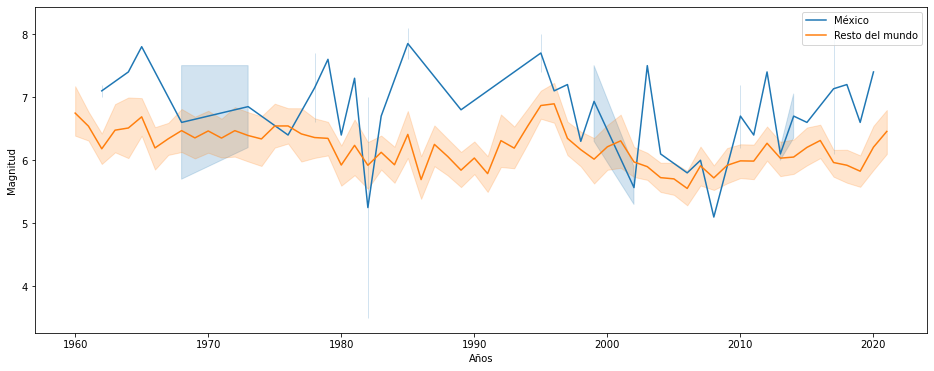

In [19]:
df_earthquakes_mex = df_earthquakes[df_earthquakes['Country'] == 'MEXICO'][['Year','Mag']].reset_index(drop=True)
plt.figure(figsize=(16,6))
sns.lineplot(data=df_earthquakes_mex, x = 'Year', y='Mag', label='México' )
sns.lineplot(data=df_earthquakes, x='Year', y='Mag', label = 'Resto del mundo')
plt.xlabel('Años')
plt.ylabel('Magnitud')

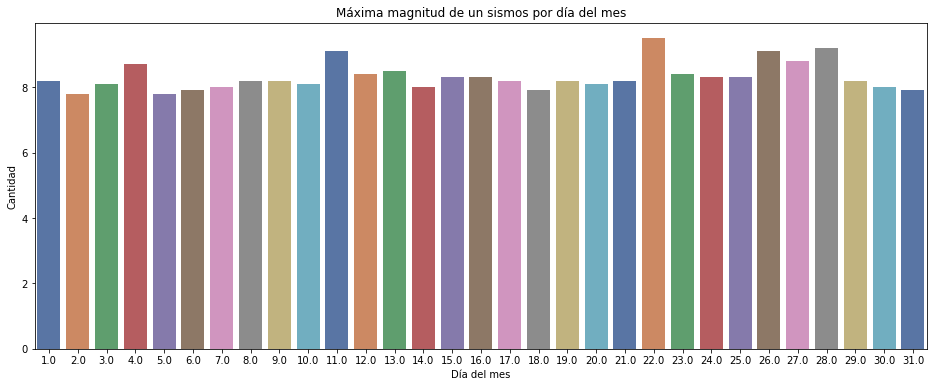

In [20]:
df_earthquakes_byDay = df_earthquakes.groupby('Dy').agg({'Mag':'max'}).reset_index()

plt.figure(figsize=(16,6))
sns.barplot(x='Dy', y='Mag', data=df_earthquakes_byDay, palette='deep')
plt.title('Máxima magnitud de un sismos por día del mes')
plt.xlabel('Día del mes')
plt.ylabel('Cantidad')
plt.show()


<AxesSubplot:xlabel='Mag', ylabel='Focal Depth (km)'>

<Figure size 1152x432 with 0 Axes>

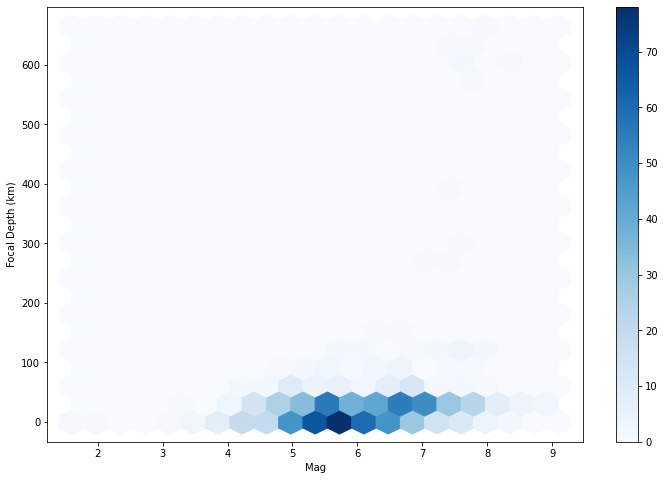

In [44]:
plt.figure(figsize=(16,6))
df_earthquakes.plot(kind='hexbin', x='Mag', y='Focal Depth (km)', gridsize=20, figsize=(12,8), cmap="Blues", sharex=False) # required to get rid of a bug )